In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pnevmoniya/sample_solution.csv
/kaggle/input/pnevmoniya/test/test_img_10340.jpeg
/kaggle/input/pnevmoniya/test/test_img_10168.jpeg
/kaggle/input/pnevmoniya/test/test_img_10613.jpeg
/kaggle/input/pnevmoniya/test/test_img_10368.jpeg
/kaggle/input/pnevmoniya/test/test_img_10036.jpeg
/kaggle/input/pnevmoniya/test/test_img_10527.jpeg
/kaggle/input/pnevmoniya/test/test_img_10020.jpeg
/kaggle/input/pnevmoniya/test/test_img_10585.jpeg
/kaggle/input/pnevmoniya/test/test_img_10276.jpeg
/kaggle/input/pnevmoniya/test/test_img_10054.jpeg
/kaggle/input/pnevmoniya/test/test_img_10298.jpeg
/kaggle/input/pnevmoniya/test/test_img_10355.jpeg
/kaggle/input/pnevmoniya/test/test_img_10511.jpeg
/kaggle/input/pnevmoniya/test/test_img_10410.jpeg
/kaggle/input/pnevmoniya/test/test_img_10096.jpeg
/kaggle/input/pnevmoniya/test/test_img_10219.jpeg
/kaggle/input/pnevmoniya/test/test_img_10057.jpeg
/kaggle/input/pnevmoniya/test/test_img_10296.jpeg
/kaggle/input/pnevmoniya/test/test_img_10407.jpeg
/kagg

# **CRISP-DM**
<img src="https://datafifty.com/wp-content/uploads/2022/02/crispdm-_2_.webp" alt="CRISP-DM" >

# **Business Understanding**

Pneumonia accounts for more than 15% of deaths in children under 5 years of age internationally. In 2015, 920,000 children under the age of 5 died from this disease. In the United States, pneumonia accounted for more than 500,000 emergency department visits per year and more than 50,000 deaths in 2015, making it one of the top 10 causes of death in the country. Although pneumonia is common, it is very difficult to make an accurate diagnosis. This requires review of the chest radiograph (CXR) by highly trained specialists and confirmation by clinical history, vital signs, and laboratory tests. Pneumonia usually appears as a hazy area or haziness on CXR. However, the diagnosis of pneumonia on CXR is complicated by a number of other conditions such as fluid overload in the lungs (pulmonary edema), hemorrhage, volume loss (atelectasia or collapse), lung cancer, or changes following radiation or surgery. . Fluid in the pleural space outside the lungs (pleural effusion) also appears as an increase in opacity on CXR. When available, comparison of the patient's CXRs obtained at different time points and correlation with clinical symptoms and history may aid in the diagnosis.

I am taking part in this competition to try to solve this problem!

* It needs to be diagnosed, so it is classification problem.
* [In this work, a deep learning(DL) model using VGG16 is utilized for detecting and classifying pneumonia using two CXR image datasets. The VGG16 with Neural Networks (NN) provides an accuracy value of 92.15%, recall as 0.9308, precision as 0.9428, and F1-Score0.937 for the first dataset. ](https://www.sciencedirect.com/science/article/pii/S1877050923000182)

In [2]:
import torch
import fastai
from fastai.vision.all import *
from ipywidgets import widgets

print(torch.__version__)
print(fastai.__version__)

2.1.2
2.7.13


# **Data understanding and preparation**

In [3]:
#Path
path = Path('/kaggle/input/pnevmoniya/train')
fls = get_image_files(path)  # fastai method to see the files inside of the path
failed = verify_images(path) # fastai method to check if pictures are corrupted
# fls 
print(f'corrupted images: {failed}')

'PosixPath' object is not iterable
corrupted images: []


**Data loaders**
Pytorch is getting data as data loaders

In [4]:
cxr = DataBlock(
    blocks = (ImageBlock, CategoryBlock), # ImageBlock - bcoz we are working with pics, CategoryBlock - bcoz our data divided into categories.
    get_items = get_image_files, # To get images uses fastai method 
    splitter = RandomSplitter(valid_pct = 0.2, seed=42), # To split the data to train and validation sets
    get_y = parent_label, # Assigns each pictures folder name as pics label. FastAI
    item_tfms = Resize(224)
)

# Data Loaders
dls = cxr.dataloaders(path)

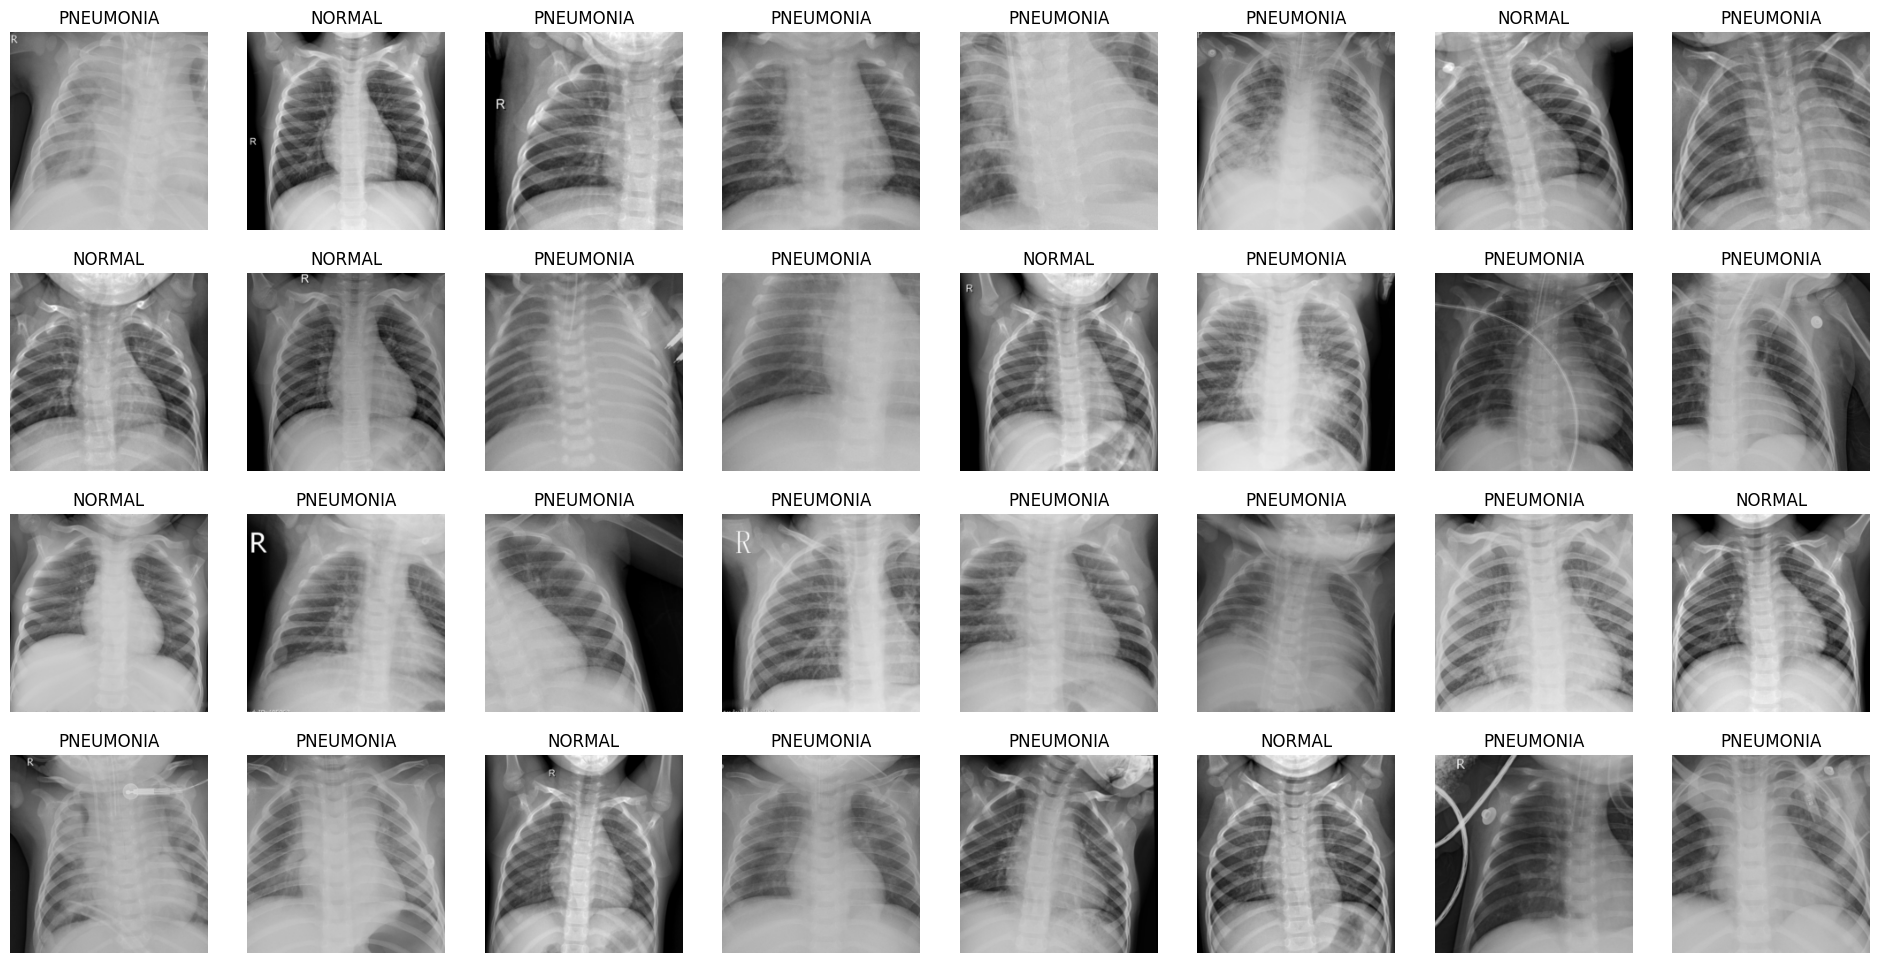

In [5]:
dls.train.show_batch(max_n=32, nrows=4)

# **Modeling and Evalution**

In [6]:
learn = cnn_learner(dls, vgg16_bn, metrics=accuracy) # vision_learner(dls, vgg16_bn, metrics=accuracy)
learn.fine_tune(4)

/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:05<00:00, 95.6MB/s] 


epoch,train_loss,valid_loss,accuracy,time
0,0.406817,0.206781,0.944391,00:59


epoch,train_loss,valid_loss,accuracy,time
0,0.145631,0.117948,0.967402,01:01
1,0.083014,0.071518,0.978907,01:00
2,0.040665,0.045409,0.987536,01:01
3,0.018451,0.037504,0.989453,01:01


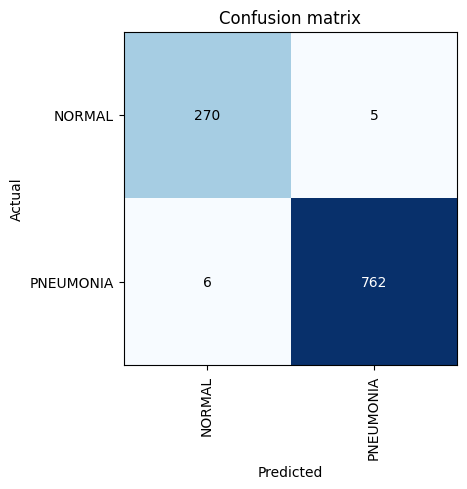

In [7]:
# Evaluation
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

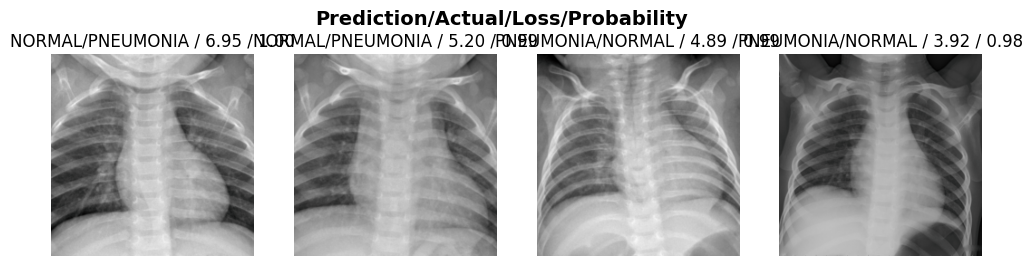

In [8]:
interp.plot_top_losses(4, nrows=1)

In [9]:
learn.export('pneumonia_classification_model.pkl')

In [10]:
import os

# Directory containing test images
test_dir = '/kaggle/input/pnevmoniya/test'

# Get a list of test image file paths
test_files = get_image_files(test_dir)

# Sort the file paths in ascending order based on the filenames
test_files = sorted(test_files)

# Create an empty list to store predictions
predictions = []

# Iterate over test images
for img_path in test_files:
    # Extract image ID from the file name
    img_id = os.path.basename(img_path)  # Extract filename including extension

    # Load and preprocess the test image
    img = PILImage.create(img_path)
    img = img.resize((224, 224))  # Resize to match the input size of the model

    # Make predictions
    pred_class, _, _ = learn.predict(img)

    # Determine label
    label = 1 if pred_class == 'PNEUMONIA' else 0

    # Append predictions to the list
    predictions.append({'id': img_id, 'labels': label})

# Convert predictions list to DataFrame
predictions_df = pd.DataFrame(predictions)

# Save predictions to a CSV file
predictions_df


,id,labels
0,test_img_10001.jpeg,1
1,test_img_10002.jpeg,0
2,test_img_10003.jpeg,0
3,test_img_10004.jpeg,1
4,test_img_10005.jpeg,0
...,...,...
619,test_img_10620.jpeg,1
620,test_img_10621.jpeg,0
621,test_img_10622.jpeg,1
622,test_img_10623.jpeg,1


# **Output**

In [11]:
# Save predictions to a CSV file
# predictions_df.drop('prediction', axis=1, inplace=True)
predictions_df['id'].sort_values(ascending=True)
predictions_df.to_csv('predictions.csv', index=False)